In [1]:
import numpy as np
from numpy.random import random
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal as MVN
import pdb
from vb_yazid import *
import scipy.io
import os
import time
from scipy.stats import multivariate_normal
from tqdm.notebook import trange, tqdm

%load_ext autoreload
%autoreload 2

DKL bleue 46.27273430526474
DKL cont 64661.24213435817
DKL totale 64707.51486866343


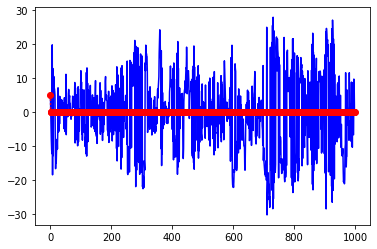

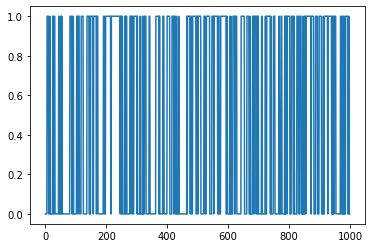

MSE 123.67151541737357


In [2]:
'''Fonctions'''

def general_TMC_model(F,H,Q,R,F_2,H_2):

    '''On fabrique un modèle triplet p(x_t,y_t|x_{t-1},y_{t-1},r_t)=N(z_t;B(r_t)z_t;\Sigma(r_t))
    possédant les mêmes lois p(x_t|x_{t-1},r_t) et p(y_t|x_{t},r_t) du JMSS caractérisé par F,H,Q et R
    si F_2=0 et H_2=0 (matrices nulles), on retombe sur le JMSS (voir Petetin  TSP June 2014).
    Attention, pour un F_2, H_2 différent de 0 cette fonction n'est valable que si H ne dépend pas de r,
    sinon il faut B[r_1,r_2,] et \Sigma[r_1,r_2,]'''

    dim_x=np.size(F,1)
    dim_y=np.size(H,1)
    K=np.size(F,0)
    B=np.zeros((K,dim_x+dim_y,dim_x+dim_y))
    sigma=np.zeros((K,dim_x+dim_y,dim_x+dim_y))

    for r in range (0,K) :
        
        F_1= F[r,]-F_2[r,]@H[r,]
        H_1= H[r,]@F[r,]-H_2[r,]@H[r,]
        B[r,]=np.block([[F_1, F_2[r,]],[H_1,H_2[r,]]]) #moyenne de p(x_t,y_t|x_{t-1},y_{t-1})
        sigma_1=Q[r,]-F_2[r,]@R@np.transpose(F_2[r,])
        sigma_21=H[r,]@Q[r,]-H_2[r,]@R@np.transpose(F_2[r,])
        sigma_12=np.transpose(sigma_21)
        sigma_22=R +H[r,]@Q[r,]@np.transpose(H[r,]) -H_2[r,]@R@np.transpose(H_2[r,])
       # print(np.linalg.solve(sigma_22,sigma_22))
       # sigma_22=np.linalg.cholesky(sigma_22)@(np.transpose(np.linalg.cholesky(sigma_22)))

        np.linalg.cholesky(sigma_22)                           
        sigma[r,]= np.block([[sigma_1,sigma_12],[sigma_21, sigma_22]])
        np.linalg.cholesky(sigma[r,]) #on vérifie qu'on a bien une matrice de covariance



    return (B,sigma)

def generer_xy(B,Sigma,mat_trans,x_init,obs_init,r_init,T):

    '''On génère suivant le modèle triplet p(x_t,y_t|x_{t-1},y_{t-1},r_t)=N(z_t;B(r_t)z_t;\Sigma(r_t))
    avec p(r_t|r_{t-1})=mat_trans. Note : on génère simultanément les états cachés et les observations '''

    dim_x=np.size(x_init,0)
    dim_y=np.size(obs_init,0)

    vect_xy=np.zeros((T,dim_x+dim_y)) #vecteur qui contient les vrais (x,y)
    vrais_r=np.zeros(T)

    vect_xy[0,: ]=np.block([x_init,obs_init  ]) #initialisation
    vrais_r[0]=r_init
    r=r_init
    
    for t in range(1,T) :
        proba_cum=np.cumsum(mat_trans[r,:])
        tirage=np.random.rand()
        r=np.argmax(tirage<proba_cum)
        vrais_r[t]=r
        vect_xy[t,:]=B[r,]@vect_xy[t-1,:]+ np.linalg.cholesky(Sigma[r,])@np.random.randn(dim_x+dim_y)

    vrais_x=vect_xy[:,0:dim_x]
    observations=vect_xy[:,dim_x:]

    return(vrais_x,observations, vrais_r.astype(int))

def joint_to_cond(B,Sigma,dim_x,dim_y):

    '''Partant de p(x_k,y_k|x_{k-1},y_{k-1},r_k)=N(z_k;B(r_k)z_{k-1},\Sigma(r_k)),
       on déduit p(x_k|x_{k-1},y_{k-1},y_k)=N(x_k;C_x(r_k)x_{k-1} + D_x(r_k)y_k + D'_x(r_k)y_{k-1};\Sigma_x(r_k))
       et p(y_k|x_{k-1},y_{k-1})= N(y_k,A_y(r_k)y_x{k-1},B_y(r_k)y_{k-1},\Sigma_y)'''

    ''' Remarques :
        1. on sait faire le filtrage/lissage exact si H_1=0. On doit trouver A_y=0 dans un modèle dans lequel on peut faire le filtrage
        2. Dans le cadre de nos applications (JMSS et loi variationnelle), D_prime_x=0'''

    ''' Attention : erreur d'approximation numérique qui fait que D_prime peut être différent de 0'''

    K=np.size(B,0)
    C_x=np.zeros((K,dim_x,dim_x))
    Sigma_x=np.zeros((K,dim_x,dim_x))
    D_x=np.zeros((K,dim_x,dim_y))
    D_prime_x=np.zeros((K,dim_x,dim_y))
    A_y=np.zeros((K,dim_y,dim_x))
    B_y=np.zeros((K,dim_y,dim_y))
    Sigma_y=np.zeros((K,dim_y,dim_y))
    
    
    for r in range(0,K):
        
        F_1=B[r,0:dim_x,0:dim_x]
        F_2=B[r,0:dim_x,dim_x :]
        H_1=B[r,dim_x:,0:dim_x]
        H_2=B[r,dim_x:,dim_x :]
       
        Sigma_11=Sigma[r,0:dim_x,0:dim_x]
        Sigma_12=Sigma[r,0:dim_x,dim_x :]
        Sigma_21=Sigma[r,dim_x:,0:dim_x]
        Sigma_22=Sigma[r,dim_x:,dim_x :]

        C_x[r,]=F_1-Sigma_12@np.linalg.solve(Sigma_22,H_1)
        D_x[r,]=np.transpose(np.linalg.solve(Sigma_22,Sigma_12.transpose()))    
        D_prime_x[r,]=F_2-Sigma_12@np.linalg.solve(Sigma_22,H_2)
        #print(D_prime_x[r,])
        Sigma_x[r,]=Sigma_11-Sigma_12@np.linalg.solve(Sigma_22,Sigma_12.transpose())

        A_y[r,]=H_1
        B_y[r,]=H_2
        Sigma_y[r,]=Sigma_22

    return(C_x,D_x,D_prime_x,Sigma_x,A_y,B_y,Sigma_y)

def cond_to_joint(C_x,D_x,D_prime_x,Sigma_x,A_y,B_y,Sigma_y):

    '''Fonction réciproque de la fontion cond_to_joint.
       Partant dep(x_k|x_{k-1},y_{k-1},y_k)=N(x_k;C_x(r_k)x_{k-1} + D_x(r_k)y_k + D'_x(r_k)y_{k-1};\Sigma_x(r_k))
       et p(y_k|x_{k-1},y_{k-1})= N(y_k,A_y(r_k)y_x{k-1},B_y(r_k)y_{k-1},\Sigma_y), on déduit
       p(x_k,y_k|x_{k-1},y_{k-1},r_k)=N(z_k;B(r_k)z_{k-1},\Sigma(r_k))'''

    '''Remarques :
        1.A_y=0 pour filtrage/lissage exact. Le Bloc Sud-Est de la matrice B doit être nul à l'arrivée
        2. Dans nos application, D_prime=0'''

    K=np.size(C_x,0)
    dim_x=np.size(C_x,1)
    dim_y=np.size(D_x,2)
    B=np.zeros((K,dim_x+dim_y,dim_x+dim_y))
    Sigma=np.zeros((K,dim_x+dim_y,dim_x+dim_y))

    for r in range(0,K):
       
        F_1=C_x[r,]+D_x[r,]@A_y[r,]
        F_2=D_prime_x[r,]+D_x[r,]@B_y[r,]
        Sigma_12=D_x[r,]@Sigma_y[r,]
        Sigma_11=Sigma_x[r,]+D_x[r,]@Sigma_y[r,]@(D_x[r,].transpose())
        Sigma_21=Sigma_12.transpose()
       

        H_1=A_y[r,]
        H_2=B_y[r,]
        Sigma_22=Sigma_y[r,]

        B[r,0:dim_x,0:dim_x]=F_1
        B[r,0:dim_x,dim_x :]=F_2
        B[r,dim_x:,0:dim_x]=H_1
        B[r,dim_x:,dim_x :]=H_2
        Sigma[r,0:dim_x,0:dim_x]=Sigma_11
        Sigma[r,0:dim_x,dim_x :]=Sigma_12
        Sigma[r,dim_x:,0:dim_x]=Sigma_21
        Sigma[r,dim_x:,dim_x :]=Sigma_22
       

        np.linalg.cholesky(Sigma[r,]) #on vérifie qu'on a bien une matrice de covariance
    
    return(B,Sigma)

class QVAR:

    def init_q_var(self,F,H,Q,R,mat_trans):
            
        '''On initialise les paramètres de q(x_k|x_{k-1},y_{k-1},y_k)=N(x_k;C_x(r_k)x_{k-1} + D_x(r_k)y_k + D'_x(r_k)y_{k-1}+cste_x(r_k);\Sigma_x(r_k))
        et q(y_k|x_{k-1},y_{k-1})= N(y_k,A_y(r_k)y_x{k-1}+B_y(r_k)y_{k-1}+cste_y;\Sigma_y), à partir de H_2 et F_2
        du papier TSP June 2014, de manière à ce que le modèle q() soit déjà proche de p().
        Par défaut D'_x= 0 et cste_x=0, cste_y=0 (à voir si on optimise aussi /t à ses paramètres?)
        A_y=0, condition pour pouvoir mener les calculs exactements'''
        good_init=0
        K=np.size(F,0)
        dim_x=np.size(F,1)
        dim_y=np.size(H,1)
        C_x=np.zeros((K,dim_x,dim_x))
        Sigma_x=np.tile(np.diag(np.ones(dim_x)),[K,1,1])
        D_x=np.zeros((K,dim_x,dim_y))
        D_prime_x=np.zeros((K,dim_x,dim_y)) #inutile mais on garde si on veut reconstruire le B correspondant via cond to joint
        A_y=np.zeros((K,dim_y,dim_x))   #inutile mais on garde si on veut reconstruire le B correspondant via cond to joint
        B_y=np.zeros((K,dim_y,dim_y))
        Sigma_y=Sigma_x=np.tile(np.diag(np.ones(dim_y)),[K,1,1])
        cste_x=np.zeros((K,dim_x))
        cste_y=np.zeros((K,dim_y))
        H_2=np.zeros((K,dim_y,dim_y))
        F_2=np.zeros((K,dim_x,dim_y))
        F_1=np.zeros((K,dim_x,dim_y))
        
        mat_trans_var = np.identity(K) + np.random.uniform(low=0., high=.4, size=(K, K))
        mat_trans_var /= mat_trans_var.sum(axis=1, keepdims=1)
        
        if good_init==1:
            
            for r in range(0,K):
                mat_trans_var=mat_trans
                H_2[r,]=H[r,]@F[r,]@np.linalg.pinv(H[r,])
                F_2[r,]=Q[r,]@H[r,].transpose()@np.linalg.inv(R+H[r,]@Q[r,]@H[r,].transpose())@H_2[r,]
                F_1[r,]= F[r,]-F_2[r,]@H[r,]
                Sigma_11=Q[r,] -F_2[r,]@R@np.transpose(F_2[r,])
                Sigma_21=H[r,]@Q[r,] -H_2[r,]@R@np.transpose(F_2[r,])
                Sigma_12=np.transpose(Sigma_21)
                Sigma_22=R +H[r,]@Q[r,]@np.transpose(H[r,]) # -H_2[r,]@R@np.transpose(H_2[r,])
                C_x[r,]=F_1[r,]
                D_x[r,]=np.transpose(np.linalg.solve(Sigma_22,Sigma_12.transpose()))
                Sigma_x[r,]=Sigma_11 -Sigma_12@np.linalg.solve(Sigma_22,Sigma_12.transpose())
                B_y[r,]=H_2[r,]
                Sigma_y[r,]=Sigma_22
                D_prime_x[r,]=F_2[r,]-np.transpose(np.linalg.solve(Sigma_22,Sigma_12.transpose()))@H_2[r,]
                np.linalg.cholesky(Sigma_y[r,])
                np.linalg.cholesky(Sigma_x[r,])
            
        #print(D_prime_x)
        self.C_x=C_x
        self.D_x=D_x
        self.D_prime_x=D_prime_x
        self.Sigma_x=Sigma_x
        self.cste_x=cste_x
        self.B_y=B_y
        self.Sigma_y=Sigma_y
        self.cste_y=cste_y
        self.mat_trans=mat_trans_var
        
        return(self)
    
    def vt_to_qvar(self,vt):
        self.C_x=vt.C_x.detach().numpy()
        self.D_x=vt.D_x.detach().numpy()
        self.D_prime_x=vt.D_prime_x.detach().numpy()
        self.Sigma_x=vt.sigma_x.detach().numpy()
        self.cste_x=vt.cte_x.detach().numpy()
        self.B_y=vt.B_y.detach().numpy()
        self.Sigma_y=vt.sigma_y.detach().numpy()
        self.cste_y=vt.cte_y.detach().numpy()
        self.mat_trans=torch.softmax(vt.qr_r_1,0).transpose(0,1).detach().numpy()
        self.F=vt.F.detach().numpy()
        self.H=vt.H.detach().numpy()
        self.Q=vt.Q.detach().numpy()
        self.R=vt.R.detach().numpy()
        self.mat_trans_p=torch.softmax(vt.pr_r_1,0).transpose(0,1).detach().numpy()
        self.qr_0=vt.qr_0.detach().numpy
        
        
        
        return(self)

def logsumexp(x):
    c = np.max(x,axis=0)
    #K=np.size(x,axis=0)
    return c + np.log(np.sum(np.exp(x - c),axis=0))

def filtrage_var(q,moy_x_sachant_r,moy_xx_transpose_sachant_r,loi_filtrage_r,y,y_prec):
    
    K=np.size(moy_x_sachant_r,0)
    dim_x=np.size(moy_x_sachant_r,1)
    dim_y=np.size(y)
    log_p_r_k_1_r_k=np.zeros((K,K))
    moy_x_sachant_r1_r2=np.zeros((K,K,dim_x))
    moy_xx_transpose_sachant_r1_r2=np.zeros((K,K,dim_x,dim_x))
    var_x_sachant_r=np.zeros((K,dim_x,dim_x))
    
    for r in range(K):
     
      #print(multivariate_normal.pdf(y,mean=q.B_y[r,]@y_prec+q.cste_y[r,],cov=q.Sigma_y[r,]))
      #vraisemblance= multivariate_normal.pdf(y,mean=q.B_y[r,]@y_prec+q.cste_y[r,],cov=q.Sigma_y[r,])
      log_vraisemblance= multivariate_normal.logpdf(y,mean=q.B_y[r,]@y_prec+q.cste_y[r,],cov=q.Sigma_y[r,])
      #print(log_vraisemblance)
      #p_r_k_1_r_k[:,r]=q.mat_trans[:,r]*loi_filtrage_r*vraisemblance
      log_p_r_k_1_r_k[:,r]=np.log(q.mat_trans[:,r])+np.log(loi_filtrage_r)+log_vraisemblance
     
    loi_filtrage_r=np.exp(logsumexp(log_p_r_k_1_r_k) -logsumexp(logsumexp(log_p_r_k_1_r_k)))
    #print(loi_filtrage_r)
    loi_r_k_1_sachant_r_k= np.exp(log_p_r_k_1_r_k-logsumexp(log_p_r_k_1_r_k))
    
    #loi_r_k_1_sachant_r_k= np.exp(log_p_r_k_1_r_k-np.max(log_p_r_k_1_r_k,axis=0))/np.tile(np.sum(np.exp(log_p_r_k_1_r_k-np.max(log_p_r_k_1_r_k,axis=0)),axis=0),(K,1))
    #loi_filtrage_r=  np.sum(np.exp(log_p_r_k_1_r_k-np.max(log_p_r_k_1_r_k)),axis=0)/np.sum(np.exp(log_p_r_k_1_r_k-np.max(log_p_r_k_1_r_k)))
 
    for r1 in range(K):
        for r2 in range(K):
            moy_x_sachant_r1_r2[r1,r2,:]= loi_r_k_1_sachant_r_k[r1,r2]*(q.C_x[r2,]@moy_x_sachant_r[r1,]+q.D_x[r2,]@y+q.cste_x[r2,]+q.D_prime_x[r2,]@y_prec)
            moy_xx_transpose_sachant_r1_r2[r1,r2,]=loi_r_k_1_sachant_r_k[r1,r2]*(q.Sigma_x[r2,]+q.C_x[r2,]@moy_xx_transpose_sachant_r[r1,]@q.C_x[r2,].transpose()+np.outer(q.D_x[r2,]@y+q.D_prime_x[r2,]@y_prec,moy_x_sachant_r[r1,].transpose()@q.C_x[r2,].transpose())+np.outer(q.C_x[r2,]@moy_x_sachant_r[r1,],y.transpose()@q.D_x[r2,].transpose()+y_prec.transpose()@q.D_prime_x[r2,].transpose())+np.outer(q.D_x[r2,]@y+q.D_prime_x[r2,]@y_prec,q.D_x[r2,]@y+q.D_prime_x[r2,]@y_prec))
            
    moy_x_sachant_r=np.sum(moy_x_sachant_r1_r2,axis=0)
    
    
    moy_xx_transpose_sachant_r=np.sum(moy_xx_transpose_sachant_r1_r2,axis=0)
    
    
    for r in range(K):
            var_x_sachant_r[r,]= moy_xx_transpose_sachant_r[r,]-np.outer(moy_x_sachant_r[r,],moy_x_sachant_r[r,])
            #print(moy_x_sachant_r[r,])
            #print(np.outer(moy_x_sachant_r[r,],moy_x_sachant_r[r,]))
            #print(var_x_sachant_r[r,])
           
    #print(moy_xx_transpose_sachant_r)
    moy_filtrage =  loi_filtrage_r@moy_x_sachant_r
    
    return (moy_filtrage,moy_x_sachant_r,moy_xx_transpose_sachant_r,var_x_sachant_r,loi_filtrage_r)

def lissage_var(q,moy_x_sachant_r,loi_filtrage_r,log_beta,y,y_suiv):

     K=np.size(loi_filtrage_r)
     log_r_k_1_r_k_y_sachant_y=np.zeros((K,K))
     log_beta_prec=np.zeros(K)
     log_vraisemblance=np.zeros(K)

     for r1 in range(K):
         for r2 in range(K):
            log_vraisemblance[r2]=multivariate_normal.logpdf(y_suiv,mean=q.B_y[r2,]@y+q.cste_y[r2,],cov=q.Sigma_y[r2,])
            #print(log_beta[r2])
            log_r_k_1_r_k_y_sachant_y[r1,r2]= np.log(loi_filtrage_r[r1])+np.log(q_var.mat_trans[r1,r2])+log_vraisemblance[r2]+log_beta[r2]
            
         log_beta_prec[r1]=logsumexp(np.log(q_var.mat_trans[r1,])+ log_vraisemblance + log_beta)

     log_loi_r_k_1_r_k_sachant_y = log_r_k_1_r_k_y_sachant_y-logsumexp(logsumexp(log_r_k_1_r_k_y_sachant_y)) 
     loi_r_k_1_r_k_sachant_y=np.exp(log_loi_r_k_1_r_k_sachant_y)
    # print('r_{t+1}',np.sum(loi_r_k_1_r_k_sachant_y,axis=0))
    # print('r_t',np.sum(loi_r_k_1_r_k_sachant_y,axis=1))
     loi_lissage_r=np.exp(logsumexp(log_loi_r_k_1_r_k_sachant_y.transpose()))
     log_beta=log_beta_prec
     moy_lissage=loi_lissage_r@moy_x_sachant_r
     #print(np.sum(loi_r_k_1_r_k_sachant_y,axis=0))
     return(moy_lissage,loi_lissage_r,log_beta,loi_r_k_1_r_k_sachant_y)

    
def calcul_DKL_saut(T,loi_jointe_lissage,mat_trans,loi_saut_init):
    K=np.size(loi_saut_init)
    lissage_0=np.sum(loi_jointe_lissage[0,],axis=1)
    #print('lissage_0',lissage_0)
    DKL=np.sum(lissage_0*np.log(lissage_0/loi_saut_init))
    DKL_init=np.sum(lissage_0*np.log(lissage_0/loi_saut_init))
   
    
    for t in range(1,T):
        #print(DKL)
        loi_r_sachant_r_t_1_y=loi_jointe_lissage[t-1,]/((np.tile(np.sum(loi_jointe_lissage[t-1,],axis=1),(K,1))).transpose())
        #print((np.tile(np.sum(loi_jointe_lissage[t-1,],axis=1),(K,1))).transpose())
        #print(loi_r_sachant_r_t_1_y)
        DKL+= np.sum(loi_jointe_lissage[t-1,]*np.log(loi_r_sachant_r_t_1_y/mat_trans))
           

    
    #print(np.sum(loi_jointe_lissage,axis=2).shape)
    A=np.sum(loi_jointe_lissage,axis=2)
    B=np.repeat(A[:, :, np.newaxis], K, axis=2)
    #print(B)
    #C=np.transpose(B,(0,2,1))
    #print(B)
    loi_r_sachant_r_t_1_y_mat= loi_jointe_lissage/B
   # print(loi_r_sachant_r_t_1_y_mat)
    DKL_mat=DKL_init+np.sum(loi_jointe_lissage*np.log(loi_r_sachant_r_t_1_y_mat/np.tile(mat_trans[np.newaxis,:,:],(T-1,1,1))))

    #print(DKL)
    #print(DKL_mat)
    
    return(DKL,DKL_mat)

def calcul_DKL_saut_yazid(T,loi_jointe_lissage,mat_trans,loi_saut_init,observations,q):

    
    DKL=0
    
   
    
    for t in range(1,T):
        #print(DKL)
        for r1 in range(0,K):
            for r2 in range(0,K):
                vraisemblance=multivariate_normal.pdf(observations[t,],mean=q.B_y[r2,]@observations[t-1,]+q.cste_y[r2,],cov=q.Sigma_y[r2,])
                DKL+= np.log(q_var.mat_trans[r1,r2]*vraisemblance/mat_trans[r1,r2])*loi_jointe_lissage[t-1,r1,r2]
           

    
    return(DKL)


def calcul_DKL_cont(T,moy_x_sachant_r,var_x_sachant_r,loi_jointe_lissage,mat_trans,loi_saut_init,q_var,K,F,H,Q,R,observations):
    #rappel : R ne dépend pas de r
   
    DKL=0
    q_r0_T=np.sum(loi_jointe_lissage[0,],axis=1)
    dim_x=moy_x_sachant_r.shape[2]
    #print(dim_x)
    dim_y=observations.shape[1]
    #print(dim_y)
    K_k=np.zeros((K,dim_x,dim_y))
    C_tilde_k=np.zeros((K,dim_x,dim_x))
    D_tilde_k=np.zeros((K,dim_x,dim_y))
    Sigma_tilde_k=np.zeros((K,dim_x,dim_x))
    H_tilde_k=np.zeros((K,dim_y,dim_x))
    Q_tilde_k=np.zeros((K,dim_y,dim_y))
    G_k=np.zeros(K)

    for r in range(0,K):
        K_k[r,]=Q[r,]@H[r,].transpose()@np.linalg.inv(R+H[r,]@Q[r,]@H[r,].transpose())
        C_tilde_k[r,]=F[r,]-K_k[r,]@H[r,]@F[r,]
        D_tilde_k[r,]=K_k[r,]
        Sigma_tilde_k[r,]=(np.eye(dim_x)-K_k[r,]@H[r,])@Q[r,]
        H_tilde_k[r,]=H[r,]@F[r,]
        Q_tilde_k[r,]=R+H[r,]@Q[r,]@H[r,].transpose()
        G_k[r,]=np.trace(np.linalg.inv(Sigma_tilde_k[r,])@q_var.Sigma_x[r,])+np.log(np.linalg.det(Sigma_tilde_k[r,])/np.linalg.det(q_var.Sigma_x[r,]))-dim_x

    D_k=D_tilde_k-q_var.D_x
    A_k=C_tilde_k-q_var.C_x
    D_prime_k= -q_var.D_prime_x
    #print(A_k)

    #t=0  
    for r in range(0,K):
        DKL+= -q_r0_T[r]*multivariate_normal.logpdf(observations[0,],mean=H[r,]@moy_x_sachant_r[0,r,],cov=R+H[r,]@var_x_sachant_r[0,r,]@H[r,].transpose())
    #print(DKL)
    for t in range(1,T):
        
        for r1 in range(0,K):
            for r2 in range(0,K):
                alpha=1/2*(G_k[r2,]+np.trace(np.linalg.inv(Sigma_tilde_k[r2,])@A_k[r2,]@var_x_sachant_r[t-1,r1,]@A_k[r2,].transpose())+ np.transpose(A_k[r2,]@moy_x_sachant_r[t-1,r1,]+D_k[r2,]@observations[t,]+D_prime_k[r2,]@observations[t-1,])@np.linalg.inv(Sigma_tilde_k[r2,])@(A_k[r2,]@moy_x_sachant_r[t-1,r1,]+D_k[r2]@observations[t,]+D_prime_k[r2,]@observations[t-1,]))
                #print(alpha)
                DKL+=loi_jointe_lissage[t-1,r1,r2]*alpha
                beta=dim_y/2*np.log(2*np.pi)+1/2*np.log(np.linalg.det(Q_tilde_k[r2,]))+1/2*(np.trace(np.linalg.inv(Q_tilde_k[r2,])@H_tilde_k[r2,]@var_x_sachant_r[t-1,r1,]@H_tilde_k[r2,].transpose())+ np.transpose(H_tilde_k[r2,]@moy_x_sachant_r[t-1,r1,]-observations[t,])@np.linalg.inv(Q_tilde_k[r2,])@(H_tilde_k[r2,]@moy_x_sachant_r[t-1,r1,]-observations[t,]))
                #print(beta)
                DKL+= loi_jointe_lissage[t-1,r1,r2]*beta

    

    return(DKL)
    
    

    

'''principal'''


dim_x=1 # dimension etat_cache
dim_y=1 # dimension observation
K=2  #nombre de sauts
T=1000 #nombre d'observations 

#Définition du modèle (F,H,Q,R,...)

T_e=1
virage=6*np.pi/180
omega=np.array([0,virage,virage])
#sigma_Q = np.array([3,10,10,10,10,10,10])
sigma_Q = 10*np.array([1,1])
sigma_R = 1
#a=np.array([1,-0.9,0.9,-0.8,0.8,-0.7,0.7])
a=np.array([0.95,-0.95])

prob=0.8
#mat_trans=np.array([[0.8,0.1,0.1],[0.1, 0.8,0.1],[0.1,0.1,0.8]]) #p(r_t=j|r_{t-1}=i)=mat[i,j]
mat_trans1=np.diag(prob*np.ones(K))
mat_trans2=(1-prob)/(K-1)*np.ones([K,K])
np.fill_diagonal(mat_trans2,0)
mat_trans=mat_trans1+mat_trans2
#print(mat_trans)
H_def=np.identity(dim_y) # si dim_x=4 et dim_y=4
#H_def=np.array([[1.0,0,0,0],[0,0,1.0,0]])
H=np.tile(H_def,(K,1,1))#ne dépend pas de r
R=sigma_R*np.identity(dim_y) #ne dépend pas de r
F=np.zeros((K,dim_x,dim_x))
Q=np.zeros((K,dim_x,dim_x))

#F[0,:,:]=np.array([[1,T_e,0,0],[0,1,0,0],[0, 0, 1, T_e],[0, 0, 0, 1]]) 
#Q[0,:,:]=(sigma_Q[0]**2)*np.kron(np.identity(2),np.array([[T_e**3/3, T_e**2/2], [T_e**2/2, T_e]]))

for r in range (0,K) :
    F[r,]=a[r]
    Q[r,]=sigma_Q[r]
    #ome=omega[r]
    #F[r,]=np.array([[1,np.sin(ome*T_e)/ome,0, -(1-np.cos(ome*T_e))/ome],[0,np.cos(ome*T_e),0,-np.sin(ome*T_e)],[ 0, (1-np.cos(ome*T_e))/ome, 1, np.sin(ome*T_e)/ome],[0, np.sin(ome*T_e), 0, np.cos(ome*T_e)]])
    #Q[r,]=sigma_Q[r]**2*np.kron(np.identity(2),np.array([[T_e**3/3, T_e**2/2],[T_e**2/2, T_e]]))  
 
vrai_F_2=np.zeros((K,dim_x,dim_y)) #on va générer suivant le JMSS
vrai_H_2=np.zeros((K,dim_y,dim_y)) #on va générer suivant le JMSS
#vrai_F_2=0.7*F #exemple de scénario dans le cas dim_x=dim_y=4 
#vrai_H_2=0.9*F #exemple de scénario dans le cas  dim_x=dim_y=4
[B,Sigma]=general_TMC_model(F,H,Q,R,vrai_F_2,vrai_H_2)


##generation du scenario
r_init=0
#x_init =np.array([200,-500,0,10/(15*T_e)]) #état initial, x_0
#x_init =np.array([200,0,0,0])
x_init=np.array([5])
obs_init=H[r_init,]@x_init #+ np.linalg.cholesky(R)@np.random.randn(dim_y)
[vrais_x,observations,vrais_r]=generer_xy(B,Sigma,mat_trans,x_init,obs_init,r_init,T)



##Initalisation des paramètres de q_variationelle
#[C_x_var,D_x_var,D_prime_x_var,cste_x_var,Sigma_x_var,A_y_var,B_y_var,cste_y_var,Sigma_y_var,mat_trans_var]=init_q_var(F,H,Q,R,mat_trans_vrai)
q_var=QVAR()
q_var=q_var.init_q_var(F,H,Q,R,mat_trans)
#print(q_var.D_prime_x)

#[B_var,Sigma_var]=cond_to_joint(C_x_var,D_x_var,D_prime_x_var,Sigma_x_var,A_y_var,B_y_var,Sigma_y_var)

moy_filtrage=np.zeros((T,dim_x))
moy_filtrage[0,:]=x_init

moy_x_sachant_r=np.zeros((T,K,dim_x)) #E(x_t|r_t,y_{0:t})
moy_xx_transpose_sachant_r=np.zeros((T,K,dim_x,dim_x))
var_x_sachant_r=np.zeros((T,K,dim_x,dim_x))
moy_x_sachant_r[0,]=np.tile(x_init,(K,1))
var_x_sachant_r[0,]=np.tile(50*np.eye(dim_x),(K,1,1))
moy_xx_transpose_sachant_r[0,]=np.tile(var_x_sachant_r[0,0,]+np.outer(moy_x_sachant_r[0,0,],moy_x_sachant_r[0,0,]),(K,1,1))
loi_filtrage_r=np.zeros((T,K))
loi_saut_init=(1-prob)/(K-1)*np.ones(K)
loi_saut_init[0]=prob
loi_filtrage_r[0,]=loi_saut_init
loi_lissage_r=np.zeros((T,K))

for t in range(1,T):
    y_prec=observations[t-1,:]
    y=observations[t,:]
    [moy_filtrage[t,],moy_x_sachant_r[t,],moy_xx_transpose_sachant_r[t,],var_x_sachant_r[t,],loi_filtrage_r[t,]]=filtrage_var(q_var,moy_x_sachant_r[t-1,],moy_xx_transpose_sachant_r[t-1,],loi_filtrage_r[t-1,],y,y_prec)

#print('hello',moy_xx_transpose_sachant_r)
moy_lissage=np.zeros((T,dim_x))
moy_lissage[T-1,:]=moy_filtrage[T-1,:]
log_beta=np.zeros(K)
loi_lissage_r[T-1,:]=loi_filtrage_r[T-1,:]
loi_jointe_lissage = np.zeros((T-1,K,K))

for t in reversed(range(0,T-1)):
    #print(t)
    y_suiv=observations[t+1,:]
    y=observations[t,:]
    [moy_lissage[t,:],loi_lissage_r[t,:],log_beta,loi_jointe_lissage[t,]]=lissage_var(q_var,moy_x_sachant_r[t,],loi_filtrage_r[t,],log_beta,y,y_suiv)

#print(loi_jointe_lissage)
# #print(log_beta)
#print(loi_lissage_r[0,])
#plt.plot(vrais_x[:,0],vrais_x[:,2],color='blue') #tracé du scénario généré (p_y en fonction de p_x)
#plt.plot(observations[:,0],observations[:,1],color='red')
#plt.plot(moy_filtrage[:,0],moy_filtrage[:,2],color='red',linestyle='dotted',marker="o")
#plt.plot(moy_lissage[:,0],moy_lissage[:,2],color='green',linestyle='dotted',marker="o")

plt.plot(vrais_x,color='blue')
plt.plot(moy_filtrage[:,0],color='red',linestyle='dotted',marker="o")

plt.figure()
plt.plot(vrais_r)

DKL,DKL_mat=calcul_DKL_saut(T,loi_jointe_lissage,mat_trans,loi_saut_init)
print('DKL bleue',DKL)
#print('DKL bleue_mat',DKL_mat)
DKL_cont=calcul_DKL_cont(T,moy_x_sachant_r,var_x_sachant_r,loi_jointe_lissage,mat_trans,loi_saut_init,q_var,K,F,H,Q,R,observations)
print('DKL cont',DKL_cont)
DKL_totale=DKL_cont+DKL
print('DKL totale',DKL_totale)

#print(q_var.D_x)

#DKL_yazid=calcul_DKL_saut_yazid(T,loi_jointe_lissage,mat_trans_vrai,loi_saut_init,observations,q_var)
#print(DKL_yazid)


#plt.plot(vrais_x[:,],color='blue') #tracé du scénario généré (p_y en fonction de p_x)
#plt.plot(moy_filtrage[:,],color='red',linestyle='dotted',marker="o")
#plt.plot(moy_lissage[:,],color='green',linestyle='dotted',marker="o")
plt.show(block=False)
print('MSE',((moy_filtrage-vrais_x)**2).mean())
#print(loi_filtrage_r)

#for t in range(T-2,0,-1):
#    print(t)
##plt.figure()
##plt.plot(range(0,T),var_x_sachant_r[:,0,0,0])
##plt.show(block=False)

In [3]:
K = K
dim_x = dim_x
dim_y = dim_y

F_var=torch.tensor(0*np.ones((K,dim_x,dim_x)))
#Q_var= torch.tensor(np.tile(Q[0,],[K,1,1]))
Q_var=torch.tensor(1*np.tile(np.diag(np.ones(dim_x)),[K,1,1]))
R_var=torch.tensor(5*np.tile(np.diag(np.ones(dim_x)),[K,1,1]))
#H_var=torch.tensor(0.3*np.ones((K,dim_y,dim_x)))
#mat_trans_var=np.copy(mat_trans)
mat_trans_var = np.identity(K) + np.random.uniform(low=0., high=.4, size=(K, K))
#mat_trans_var /= mat_trans_var.sum(axis=1, keepdims=1)
mat_trans_var=torch.tensor(mat_trans_var.T)

#F_var = torch.tensor(F)
#Q_var = torch.tensor(Q)
H_var = torch.tensor(H)
#R_var = torch.tensor(R).unsqueeze(0).repeat(K,1,1)
pr_r_1_var= torch.clone(mat_trans_var)

qr_r_1 = torch.tensor(q_var.mat_trans).T
pr_0   = torch.tensor(loi_saut_init).reshape(-1,1).float()
qr_0   = torch.tensor(loi_saut_init).reshape(-1,1).float()

x_init_var = torch.tensor(vrais_x[0])
obs_var = (torch.tensor(observations).T)
ground_truth_var = np.copy(vrais_x)
# print(q_var.D_x)
# print(q_var.D_prime_x)
# print(q_var.Sigma_x)


args = {'F':  F_var,
         'H': H_var,
         'Q': Q_var,
         'R': R_var,
         'pr_r_1': pr_r_1_var.log(),
         'pr_0': pr_0,
         'observations': obs_var,
         'ground_truth': ground_truth_var,
         'learning_rate': 1e-1}



init_args = {'x_init': x_init_var,
             'C_x': torch.tensor(q_var.C_x),
             'D_x': torch.tensor(q_var.D_x),
             'D_prime_x': torch.tensor(q_var.D_prime_x),
             'sigma_x': torch.tensor(q_var.Sigma_x),
             'cte_x': torch.tensor(q_var.cste_x),
             'B_y': torch.tensor(q_var.B_y),
             'cte_y': torch.tensor(q_var.cste_y),
             'sigma_y': torch.tensor(q_var.Sigma_y),
             'qr_0': qr_0,
             'qr_r_1': qr_r_1.log()}

#vt = var_triple(args)
#vt._init_model(init_args)
#vt.optimizer = torch.optim.Adam(vt.parameters, lr = vt.learning_rate) 

vt = torch.load("save_self")
#vt.optimizer = torch.optim.Adam(vt.parameters, lr = vt.learning_rate) 
#vt.optimizer.param_groups[0]['lr']=1e-2



vt.train(100, plot = True)

# for num_seq in range(0,1):
#     vt.train(20, plot = False)
#     [vrais_x,observations,vrais_r]=generer_xy(B,Sigma,mat_trans,x_init,obs_init,r_init,T)
#     obs = (torch.tensor(observations).T)
#     vt.observations=obs
#     vt.T = vt.observations.shape[1]
#     vt.ground_truth=vrais_x


#print(init_args)
#print(vt.D_prime_x)
#vt=torch.load("save_self_final")
#obs = (torch.tensor(observations).T)
#vt.observations=obs
#vt.T = vt.observations.shape[1]
#vt.ground_truth=vrais_x



RuntimeError: PytorchStreamReader failed locating file data.pkl: file not found

In [ ]:
vt.optimizer.param_groups[0]['lr'] 

In [330]:
A = np.random.rand(10,2)

A, np.cumsum(A)

(array([[0.33311466, 0.10514887],
        [0.02761105, 0.69746145],
        [0.82461016, 0.53158407],
        [0.08582547, 0.40713091],
        [0.51706939, 0.27092789],
        [0.74373636, 0.03214404],
        [0.81098356, 0.09097088],
        [0.47161593, 0.80209012],
        [0.96931655, 0.02095   ],
        [0.38086345, 0.56098206]]),
 array([0.33311466, 0.43826353, 0.46587458, 1.16333603, 1.98794618,
        2.51953025, 2.60535572, 3.01248663, 3.52955603, 3.80048392,
        4.54422028, 4.57636432, 5.38734788, 5.47831876, 5.94993468,
        6.7520248 , 7.72134136, 7.74229135, 8.12315481, 8.68413687]))

In [422]:
weights = np.random.rand(40)
weights = weights / weights.sum()

import torch

def true_stratified(weights,K):

    N = int(len(weights) / K)
    # make N subdivisions, and chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
            
    return indexes

def find_c(weights,N):
    weights = np.sort(weights)
    M = len(weights)

    for k in range(M):
        kappa = weights[k]
        A_k = M - k
        B_k = weights[:k].sum()
        
        if A_k + (B_k/kappa) <= N:
            return (N - A_k)/B_k
        
    return None

def stratified(weights,N,L,c,K):

    particles_curr, states_next = [], []
    rem_particles, rem_states = [], []
    
    M = len(weights)
    if c is not None and c!=0: 
        alpha = 1/c
    else:
        alpha = 1/N

    U = np.random.rand() * alpha    
    i = 0
    
    while i < M:
        for k in range(K):
            if weights[i,k] != 0:
                U = U - weights[i,k]
                if U < 0:
                    particles_curr.append(i)
                    states_next.append(k)

                    U = U + alpha
                else:
                    rem_particles.append(i)
                    rem_states.append(k)
            i += 1
        
    while len(particles_curr) <= N - L - 1:
        idx = np.random.randint(len(rem_particles))
        particles_curr.append(rem_particles[idx])
        states_next.append(rem_states[idx])

    new_weights = np.ones(len(particles_curr))*alpha
        
    return particles_curr, states_next, new_weights
        
def fearnhead_resampling(particules,poids,moy,var,y,Q,R,F,H,mat_trans):

    dim_x=np.size(moy,1)
    dim_y=np.size(y,0)
    N=np.size(particules,0)
    K=np.size(mat_trans,0)
    
    desc_weights = np.zeros([N,K]) #descendants weights
    
    moys_new, vars_new = np.zeros([N,K]), np.zeros([N,K])
    #computes the weights of K descendants of each particle. 
    for j in range(N):
        for k in range(K):

            y_tilde=y-H[k,]@F[k,]@moy[j,]
            #print(F[k,],var[j,],F[k,].transpose(),Q[k,])
            var_pred=F[k,]@var[j,]@F[k,].transpose()+Q[k,]
            #print(f'variance predictive : {var_pred}')
            S=H[k,]@var_pred@H[k,].transpose()+ R
            desc_weights[j,k] = poids[j]*multivariate_normal.pdf(y_tilde,cov=S)*mat_trans[particules[j],k]
            K_k = var_pred@H[k,].transpose()@np.linalg.inv(S)
            #print(f'fearnhead vars_new without var_pred: {np.eye(dim_x)-K_k@H[k,]}')
            #print(f'variance filtre: {(np.eye(dim_x)-K_k@H[k,])@var_pred}')
            vars_new[j,k] = (np.eye(dim_x)-K_k@H[k,])@var_pred
            moys_new[j,k] = F[k,]@moy[j,]+K_k@y_tilde

    desc_weights = desc_weights / desc_weights.sum()
    sorted_weights = np.sort(desc_weights.reshape(-1,))

    c = find_c(sorted_weights, N)
    moys_final, vars_final = [], []
    c = None
    
    if c is not None and c!= 0:
        set_1 = (desc_weights >= 1/c)*1
        L = (set_1).sum()

        set_1 = set_1 * desc_weights
        set_2 = ((desc_weights < 1/c)*1)*desc_weights

        particles_curr_set2, states_next_set2, weights_set2 = stratified(set_2, N, L, c, K)
        particles_curr_set1, states_next_set1, weights_set1 = [], [], []

        for i in range(N):
            for k in range(K):
                if set_1[i,k] != 0.:
                    particles_curr_set1.append(i)
                    states_next_set1.append(k)
                    weights_set1.append(desc_weights[i,k])
                    
        particles_curr = particles_curr_set1 + particles_curr_set2
        states_next = states_next_set1 + states_next_set2
        new_weights = weights_set1 + list(weights_set2)
        
        for ancestor, descendant in zip(particles_curr, states_next):
            moys_final.append(moys_new[ancestor, descendant])
            vars_final.append(vars_new[ancestor, descendant])
        
    else:
        vars_new, moys_new, desc_weights = vars_new.reshape(-1,), moys_new.reshape(-1,), desc_weights.reshape(-1,)
        idxs = true_stratified(desc_weights, N)
        
        vars_final, moys_final, new_weights = vars_new[idxs], moys_new[idxs], desc_weights[idxs]
        particles_curr = []
        states_next = (np.zeros([N,K],'i') + np.arange(K)).reshape(-1,)[idxs]
    
    #print(f'\nOUTPUT RESAMPLING : {(np.array(vars_final) < 0).sum()}')
            
    return particles_curr, states_next, np.array(new_weights), np.array(moys_final), np.array(vars_final)

def bootstrap_fearnhead(particules,poids,moy,var,y,Q,R,F,H,mat_trans):
    
    dim_x=np.size(moy,1)
    dim_y=np.size(y,0)
    N=np.size(particules,0)
    K=np.size(mat_trans,0)
    
    curr_particles, next_states, weights, moy, var = fearnhead_resampling(particules,poids,moy,var,y,Q,R,F,H,mat_trans)
    
    moy = moy.reshape(-1,dim_x)
    var = var.reshape(-1,dim_x,dim_x)
    estime=weights@moy
    particules = next_states
    
    #print(f'\nOUTPOUT BOOTSTRAP FEARNHEAD: {(var.reshape(-1,) < 0).sum()}')
        
    return(estime,particules,poids,moy,var)

a, *rem = bootstrap_fearnhead(particules,poids,moy_particules,var_particules,y,Q,R,F,H,mat_trans) 

In [482]:
def true_stratified(weights,N):

    # make N subdivisions, and chose a random position within each one
    positions = (random(N) + range(N)) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def find_c(weights,N):
    weights = np.sort(weights)
    M = len(weights)
    for k in range(M):
        kappa = weights[k]
        A_k = M - k
        B_k = weights[:k].sum()
        if A_k + (B_k/kappa) <= N:
            return (N - A_k)/B_k
    return None

def stratified(weights,N,L,c,K):
    particles_curr, states_next = [], []
    rem_particles, rem_states = [], []
    M = len(weights)
    if c is not None and c!=0:
        alpha = 1/c
    else:
        alpha = 1/N
    U = np.random.rand() * alpha
    i = 0
    while i < M:
        for k in range(K):
            if weights[i,k] != 0:
                U = U - weights[i,k]
                if U < 0:
                    particles_curr.append(i)
                    states_next.append(k)
                    U = U + alpha
                else:
                    rem_particles.append(i)
                    rem_states.append(k)
            i += 1
    while len(particles_curr) <= N - L - 1:
        idx = np.random.randint(len(rem_particles))
        particles_curr.append(rem_particles[idx])
        states_next.append(rem_states[idx])
    new_weights = np.ones(len(particles_curr))*alpha
    return particles_curr, states_next, new_weights

def fearnhead_resampling(particules,poids,moy,var,y,Q,R,F,H,mat_trans):
    dim_x=np.size(moy,1)
    dim_y=np.size(y,0)
    N=np.size(particules,0)
    K=np.size(mat_trans,0)
    desc_weights = np.zeros([N,K]) #descendants weights
    moys_new, vars_new = np.zeros([N,K]), np.zeros([N,K])
    
    #computes the weights of K descendants of each particle.
    #print(len(particules))
    for j in range(N):
        for k in range(K):
            y_tilde=y-H[k,]@F[k,]@moy[j,]
            #print(F[k,],var[j,],F[k,].transpose(),Q[k,])
            var_pred=F[k,]@var[j,]@F[k,].transpose()+Q[k,]
            #print(f'variance predictive : {var_pred}')
            S=H[k,]@var_pred@H[k,].transpose()+ R
            desc_weights[j,k] = poids[j]*multivariate_normal.pdf(y_tilde,cov=S)*mat_trans[particules[j],k]
            K_k = var_pred@H[k,].transpose()@np.linalg.inv(S)
            #print(f'fearnhead vars_new without var_pred: {np.eye(dim_x)-K_k@H[k,]}')
            #print(f'variance filtre: {(np.eye(dim_x)-K_k@H[k,])@var_pred}')
            vars_new[j,k] = (np.eye(dim_x)-K_k@H[k,])@var_pred
            moys_new[j,k] = F[k,]@moy[j,]+K_k@y_tilde
            
    desc_weights = desc_weights / desc_weights.sum()
    desc_weights = desc_weights.reshape(-1,)
    sorted_weights = np.sort(desc_weights.reshape(-1,))
    
    states = (np.zeros([N,K],'i') + np.arange(K)).reshape(-1,)
    vars_, moys_ = vars_new.reshape(-1,), moys_new.reshape(-1,)
    
    c = find_c(sorted_weights, N)
    moys_final, vars_final = [], []
    #c = None
    
    if c is not None and c!= 0:
        print('c is not None')
        set_1 = (desc_weights >= 1/c)*1
        L = (set_1).sum()
        set_1 = set_1 * desc_weights
        set_2 = ((desc_weights < 1/c)*1)*desc_weights
        
        idxs_set2 = true_stratified(set_2 / set_2.sum(), N - L)
        idxs_set1 = []
        new_weights = []
        for i in range(N*K):
            if set_1[i] != 0.:
                idxs_set1.append(i)
                new_weights.append(desc_weights[i])
            else:
                new_weights.append(1/c)
        
        new_weights = np.array(new_weights)
        idxs = idxs_set1 + list(idxs_set2)
        vars_final, moys_final, new_weights = vars_[idxs], moys_[idxs], new_weights[idxs]
        states_next = states[idxs]
        particles_curr = []
        
    else:

        idxs = true_stratified(desc_weights, N)
        vars_final, moys_final, new_weights = vars_[idxs], moys_[idxs], np.ones(N)/N
        particles_curr = []
        states_next = states[idxs]
        
    #print(f'\nOUTPUT RESAMPLING : {(np.array(vars_final) < 0).sum()}')
    return particles_curr, states_next, np.array(new_weights), np.array(moys_final), np.array(vars_final)

def bootstrap_fearnhead(particules,poids,moy,var,y,Q,R,F,H,mat_trans):
    dim_x=np.size(moy,1)
    dim_y=np.size(y,0)
    N=np.size(particules,0)
    K=np.size(mat_trans,0)
    curr_particles, next_states, weights, moy, var = fearnhead_resampling(particules,poids,moy,var,y,Q,R,F,H,mat_trans)
    moy = moy.reshape(-1,dim_x)
    var = var.reshape(-1,dim_x,dim_x)

    estime=weights@moy
    particules = next_states
    #print(f'\nOUTPOUT BOOTSTRAP FEARNHEAD: {(var.reshape(-1,) < 0).sum()}')
    return(estime,particules,poids,moy,var)

In [483]:
def filtre_kalman_pmc(F,H,Q,R,B,sigma,moy,var,z,z_prec,dim_x,dim_y):
    
    pred_moy= B@np.concatenate((moy,z_prec))
    pred_cov=B[0:dim_x+dim_y,0:dim_x]@var@B[0:dim_x+dim_y,0:dim_x].transpose()+sigma
    moy=pred_moy[0:dim_x]+pred_cov[0:dim_x,dim_x:dim_x+dim_y]@np.linalg.inv(pred_cov[dim_x:dim_x+dim_y,dim_x:dim_x+dim_y])@(z-pred_moy[dim_x:dim_x+dim_y])
    var=pred_cov[0:dim_x,0:dim_x]-pred_cov[0:dim_x,dim_x:dim_x+dim_y]@np.linalg.inv(pred_cov[dim_x:dim_x+dim_y,dim_x:dim_x+dim_y])@pred_cov[0:dim_x,dim_x:dim_x+dim_y].transpose()
    
#     pred_moy=F@moy
#     pred_cov=F@var@F.transpose()+Q
    
#     S=R+H@pred_cov@H.transpose()
#     K=pred_cov@H.transpose()@np.linalg.inv(S)
#     y_tilde=z-H@pred_moy
    
#     moy=pred_moy+K@y_tilde
#     var=pred_cov - K@H@pred_cov
    
    
    
    return(moy,var)


def multinomial_resample(weights):
    """ This is the naive form of roulette sampling where we compute the
    cumulative sum of the weights and then use binary search to select the
    resampled point based on a uniformly distributed random number. Run time
    is O(n log n). You do not want to use this algorithm in practice; for some
    reason it is popular in blogs and online courses so I included it for
    reference.

   Parameters
   ----------

    weights : list-like of float
        list of weights as floats

    Returns
    -------

    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, random(len(weights)))

def FiltreParticulaire_bootstrap(particules,poids,moy,var,y,Q,R,F,H,mat_trans):
    
    dim_x=np.size(moy,1)
    dim_y=np.size(y,0)
    N=np.size(particules,0)
    K=np.size(mat_trans,0)
    
    for j in range(0,N) :
        
        #print(mat_trans[particules[j],])
        particules[j]=np.random.choice(range(0,K),1,p=mat_trans[particules[j],])

        y_tilde=y-H[particules[j],]@F[particules[j],]@moy[j,]
        
        var_pred=F[particules[j],]@var[j,]@F[particules[j],].transpose()+Q[particules[j],]
        
        S=H[particules[j],]@var_pred@H[particules[j],].transpose()+ R
       
        #print(multivariate_normal(y_tilde,cov=S))
        poids[j]=poids[j]*multivariate_normal.pdf(y_tilde,cov=S)
       
        K_k=var_pred@H[particules[j],].transpose()@np.linalg.inv(S)
         
        var[j,]=(np.eye(dim_x)-K_k@H[particules[j],])@var_pred
        
        moy[j,]=F[particules[j],]@moy[j,]+K_k@y_tilde
        
              
    poids=poids/np.sum(poids)
    #print(moy)
    estime=poids@moy
    neff=1/np.sum(poids**2)
    #print(moy)

    if neff/N <0.3:
        #print(poids)
        index = multinomial_resample(poids)
         
        poids=np.ones(N)/N
        particules=particules[index,]
        moy=moy[index,]
        var=var[index,]
        
    return(estime,particules,poids,moy,var)



def filtre_imm(F,Q,H,R,moyenne_selon_r,variance_selon_r,loi_selon_r,mat_trans,y):
    
    K=np.size(mat_trans,0)
    dim_x=np.size(moyenne_selon_r,1)
    matrice_num=np.zeros((K,K))
    vraisemblance=np.zeros(K)
    for r_1 in range(0,K):
        for r_2 in range(0,K):
            matrice_num[r_1,r_2]=loi_selon_r[r_1]*mat_trans[r_1,r_2]
    
    
    loi_r_k_sachant_passe=np.sum(matrice_num,0)
    loi_selon_r_predite=matrice_num/np.tile(np.sum(matrice_num,0),(K,1))
    #print(np.sum(loi_selon_r_predite,axis=0))
    moyenne_selon_r_predite=np.copy(moyenne_selon_r)
    variance_selon_r_predite=np.copy(variance_selon_r)

    #print('moyenne_selon_r_predite',moyenne_selon_r_predite)

    for r in range(0,K):
        x_0=np.zeros(dim_x)  
        P_0=np.zeros((dim_x,dim_x))
        for r_1 in range(0,K):
                x_0 +=moyenne_selon_r_predite[r_1,]*loi_selon_r_predite[r_1,r]   
        for r_1 in range(0,K):
                P_0+=(variance_selon_r_predite[r_1,]+(moyenne_selon_r_predite[r_1,]-x_0)@(moyenne_selon_r_predite[r_1,]-x_0).transpose())*loi_selon_r_predite[r_1,r]
        
        #print('x_0',x_0)
        #print('moyenne_selon_r',moyenne_selon_r[r,])
        
        x_pred=F[r,]@x_0
        P_pred=F[r,]@P_0@F[r,].transpose()+Q[r,]

   

        y_tilde=y-H[r,]@x_pred
        S_k = H[r,]@P_pred@H[r,].transpose()+R
        K_k = P_pred@H[r,]@np.linalg.inv(S_k)

        moyenne_selon_r[r,]=x_pred + K_k@y_tilde
        variance_selon_r[r,]=P_pred-K_k@H[r,]@P_pred

        vraisemblance[r]=multivariate_normal.pdf(y_tilde,cov=S_k)

    
    loi_selon_r=loi_r_k_sachant_passe*vraisemblance/np.sum(loi_r_k_sachant_passe*vraisemblance)
    estime=loi_selon_r@moyenne_selon_r
    
    return(estime,moyenne_selon_r,variance_selon_r,loi_selon_r)


    

  0%|          | 0/1 [00:00<?, ?it/s]

c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
c is not None
temps_moyen_exact 0.00048363329184175743
temps_moyen_part 0.023586174454351867


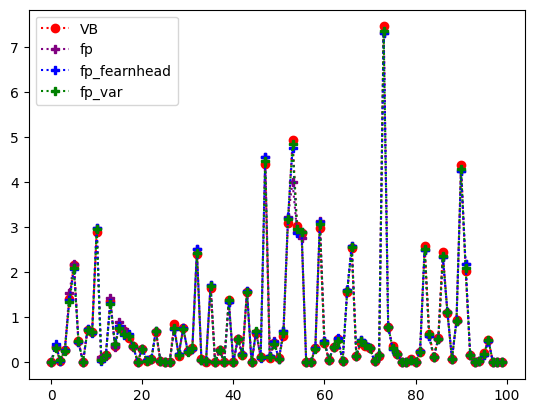

In [488]:
P=1
vt=torch.load("save_self_final")
q_var_test=QVAR()
q_var_init=QVAR()
q_var_test=q_var_test.vt_to_qvar(vt)
q_var_init.init_q_var(F,H,Q,R,mat_trans)
#q_var_test.mat_trans=q_var_init.mat_trans

F_var=q_var_test.F
H_var=q_var_test.H
Q_var=q_var_test.Q
R_var=q_var_test.R[0,]
mat_trans_var=q_var_test.mat_trans_p

T=100
MSE_vb=np.zeros((P,T))
MSE_vb_init=np.zeros((P,T))
MSE_fp=np.zeros((P,T))
MSE_fp_fh=np.zeros((P,T))
MSE_fp_var=np.zeros((P,T))
MSE_imm=np.zeros((P,T))
MSE_kalm=np.zeros((P,T))
temps_filtrage_exact=np.zeros((P,T))
temps_filtrage_part=np.zeros((P,T))

for p in tqdm(range(0,P)) :
    
    #vrais_x_test=vrais_x
    #observations_test=observations
    #vrais_r_test=vrais_r
    
    [vrais_x_test,observations_test,vrais_r_test]=generer_xy(B,Sigma,mat_trans,x_init,obs_init,r_init,T)
    
    moy_filtrage=np.zeros((T,dim_x))
    moy_filtrage[0,:]=x_init
    moy_x_sachant_r=np.zeros((T,K,dim_x)) #E(x_t|r_t,y_{0:t})
    moy_xx_transpose_sachant_r=np.zeros((T,K,dim_x,dim_x))
    var_x_sachant_r=np.zeros((T,K,dim_x,dim_x))
    moy_x_sachant_r[0,]=np.tile(x_init,(K,1))
    var_x_sachant_r[0,]=np.tile(50*np.eye(dim_x),(K,1,1))
    moy_xx_transpose_sachant_r[0,]=np.tile(var_x_sachant_r[0,0,]+np.outer(moy_x_sachant_r[0,0,],moy_x_sachant_r[0,0,]),(K,1,1))
    loi_filtrage_r=np.zeros((T,K))
    loi_saut_init=(1-prob)/(K-1)*np.ones(K)
    loi_saut_init[0]=prob
    loi_filtrage_r[0,]=loi_saut_init
    
    moy_filtrage_init=np.zeros((T,dim_x))
    moy_filtrage_init[0,:]=x_init
    moy_x_sachant_r_init=np.zeros((T,K,dim_x)) #E(x_t|r_t,y_{0:t})
    moy_xx_transpose_sachant_r_init=np.zeros((T,K,dim_x,dim_x))
    var_x_sachant_r_init=np.zeros((T,K,dim_x,dim_x))
    moy_x_sachant_r_init[0,]=np.tile(x_init,(K,1))
    var_x_sachant_r_init[0,]=np.tile(50*np.eye(dim_x),(K,1,1))
    moy_xx_transpose_sachant_r_init[0,]=np.tile(var_x_sachant_r_init[0,0,]+np.outer(moy_x_sachant_r_init[0,0,],moy_x_sachant_r_init[0,0,]),(K,1,1))
    loi_filtrage_r_init=np.zeros((T,K))
    loi_filtrage_r_init[0,]=loi_saut_init
    
    moy_kalman=np.zeros((T,dim_x))
    moy_kalman[0,:]=x_init
    var_kalman=np.zeros((T,dim_x,dim_x))
    var_kalman[0,]=50*np.eye(dim_x)
    
   
    N=50
    var_particules=np.tile(50*np.eye(dim_x),(N,1,1))
    moy_particules=np.tile(1.0*x_init,(N,1))
    particules=np.random.choice(range(0,K),N,p=loi_saut_init)
    poids=np.ones(N)/N
    moy_fp=np.zeros((T,dim_x))
    moy_fp[0,]=x_init
    
    var_particules_fh=np.tile(50*np.eye(dim_x),(N,1,1))
    moy_particules_fh=np.tile(1.0*x_init,(N,1))
    particules_fh=np.random.choice(range(0,K),N,p=loi_saut_init)
    poids_fh=np.ones(N)/N
    moy_fp_fh=np.zeros((T,dim_x))
    moy_fp_fh[0,]=x_init
    
    var_particules_var=np.tile(50*np.eye(dim_x),(N,1,1))
    moy_particules_var=np.tile(1.0*x_init,(N,1))
    particules_var=np.random.choice(range(0,K),N,p=loi_saut_init)
    poids_var=np.ones(N)/N
    moy_fp_var=np.zeros((T,dim_x))
    moy_fp_var[0,]=x_init
    
    
    moy_imm=np.zeros((T,dim_x))
    moy_imm[0,:]=x_init
    moy_x_sachant_r_imm=np.zeros((T,K,dim_x)) #E(x_t|r_t,y_{0:t})
    var_x_sachant_r_imm=np.zeros((T,K,dim_x,dim_x))
    moy_x_sachant_r_imm[0,]=np.tile(x_init,(K,1))
    var_x_sachant_r_imm[0,]=np.tile(50*np.eye(dim_x),(K,1,1))
    loi_filtrage_r_imm=np.zeros((T,K))
    loi_filtrage_r_imm[0,]=loi_saut_init
    
    
    
    for t in range(1,T):
        y_prec=observations_test[t-1,:]
        y=observations_test[t,:]
        t_exact = time.time()
        [moy_filtrage[t,],moy_x_sachant_r[t,],moy_xx_transpose_sachant_r[t,],var_x_sachant_r[t,],loi_filtrage_r[t,]]=filtrage_var(q_var_test,moy_x_sachant_r[t-1,],moy_xx_transpose_sachant_r[t-1,],loi_filtrage_r[t-1,],y,y_prec)
        temps_filtrage_exact[p,t]=time.time() - t_exact
        [moy_filtrage_init[t,],moy_x_sachant_r_init[t,],moy_xx_transpose_sachant_r_init[t,],var_x_sachant_r_init[t,],loi_filtrage_r_init[t,]]=filtrage_var(q_var_init,moy_x_sachant_r_init[t-1,],moy_xx_transpose_sachant_r_init[t-1,],loi_filtrage_r_init[t-1,],y,y_prec)

        #print(B)
        [moy_kalman[t,], var_kalman[t,]]=filtre_kalman_pmc(F[vrais_r_test[t],],H[vrais_r_test[t],],Q[vrais_r_test[t],],R,B[vrais_r_test[t],],Sigma[vrais_r_test[t],],moy_kalman[t-1,],var_kalman[t-1,],y,y_prec,dim_x,dim_y)
        #print(moy_kalman[t,])
        t_part=time.time()
        [moy_fp[t,],particules,poids,moy_particules,var_particules]=FiltreParticulaire_bootstrap(particules,poids,moy_particules,var_particules,y,Q,R,F,H,mat_trans)
        [moy_fp_fh[t,],particules_fh,poids_fh,moy_particules_fh,var_particules_fh]=bootstrap_fearnhead(particules_fh,poids_fh,moy_particules_fh,var_particules_fh,y,Q,R,F,H,mat_trans)
        temps_filtrage_part[p,t]=time.time() - t_part
        [moy_fp_var[t,],particules_var,poids_var,moy_particules_var,var_particules_var]=FiltreParticulaire_bootstrap(particules_var,poids_var,moy_particules_var,var_particules_var,y,Q_var,R_var,F_var,H_var,mat_trans_var)

        [moy_imm[t,],moy_x_sachant_r_imm[t,], var_x_sachant_r_imm[t,], loi_filtrage_r_imm[t,]]=filtre_imm(F,Q,H,R,moy_x_sachant_r_imm[t-1,], var_x_sachant_r_imm[t-1,], loi_filtrage_r_imm[t-1,],mat_trans,y);
    
    #ref=moy_kalman
    ref=vrais_x_test
    MSE_vb[p,]=np.sum((moy_filtrage-ref)**2,axis=1)
    MSE_vb_init[p,]=np.sum((moy_filtrage_init-ref)**2,axis=1)
    MSE_fp[p,]=np.sum((moy_fp-ref)**2,axis=1)
    MSE_fp_fh[p,] = np.sum((moy_fp_fh-ref)**2,axis=1)
    MSE_fp_var[p,]=np.sum((moy_fp_var-ref)**2,axis=1)
    MSE_imm[p,]=np.sum((moy_imm-ref)**2,axis=1)
    MSE_kalm[p,]=np.sum((moy_kalman-vrais_x_test)**2,axis=1)    
#     plt.figure()  
#     plt.plot(vrais_x[:,0],vrais_x[:,2],color='blue') #tracé du scénario généré (p_y en fonction de p_x)
#     plt.plot(moy_filtrage[:,0],moy_filtrage[:,2],color='red',linestyle='dotted',marker="o")
#     plt.plot(moy_kalman[:,0],moy_kalman[:,2],color='green',linestyle='dotted',marker="+")
#     plt.plot(moy_fp[:,0],moy_fp[:,2],color='yellow',linestyle='dotted',marker="P")
#     plt.plot(moy_imm[:,0],moy_imm[:,2],color='black',linestyle='--',marker="D")
    



#     plt.figure()
#     plt.plot(moy_filtrage[:,1],color='red',linestyle='dotted',marker="o")
#     plt.plot(moy_kalman[:,1],color='green',linestyle='dotted',marker="+")
#     plt.plot(moy_fp[:,1],color='yellow',linestyle='dotted',marker="P")
#     plt.plot(moy_imm[:,1],color='black',linestyle='--',marker="D")
#     plt.plot(vrais_x[:,1],color='blue')
                      
# plt.figure()
# plt.plot(np.mean(MSE_vb,axis=0)/np.mean(MSE_vb,axis=0),color='red',linestyle='dotted',marker="o")
# plt.plot(np.mean(MSE_fp,axis=0)/np.mean(MSE_vb,axis=0),color='yellow',linestyle='dotted',marker="P")   
# plt.plot(np.mean(MSE_imm,axis=0)/np.mean(MSE_vb,axis=0),color='black',linestyle='--',marker="D")
plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(np.mean(MSE_vb,axis=0),color='red',linestyle='dotted',marker="o", label = "VB")
#plt.plot(np.mean(MSE_vb_init,axis=0),color='brown',marker="o")
plt.plot(np.mean(MSE_fp,axis=0),color='purple',linestyle='dotted',marker="P", label = "fp")   
plt.plot(np.mean(MSE_fp_fh,axis=0),color='blue',linestyle='dotted',marker="P", label ="fp_fearnhead") 
plt.plot(np.mean(MSE_fp_var,axis=0),color='green',linestyle='dotted',marker="P", label ="fp_var")  
#plt.plot(np.mean(MSE_imm,axis=0),color='black',linestyle='--',marker="D")

print("temps_moyen_exact",np.mean(temps_filtrage_exact[:,1:]))
print("temps_moyen_part",np.mean(temps_filtrage_part[:,1:]))
plt.legend()

In [485]:
MSE_fp_fh.sum()

79.97167570786101

In [486]:
MSE_fp.sum()

79.90562080864765

In [460]:
((MSE_fp - MSE_fp_fh)*1).sum()

0.5865410956409599

In [242]:
MSE_fp

array([[0.00000000e+00, 3.09087931e-01, 1.31315777e+00, 5.65066098e-01,
        4.01899041e+00, 5.26449494e-02, 2.04965905e-01, 2.57725949e-02,
        1.57020787e-01, 3.60355673e+00, 3.63397362e-01, 2.65082647e-01,
        2.53487140e-02, 3.79306688e+00, 3.13432916e+00, 3.02021619e+00,
        4.58640548e-01, 8.28528611e-01, 7.26353984e-02, 2.76003992e-05,
        3.63176595e+00, 1.56493553e-01, 6.92695081e+00, 6.99484689e-02,
        1.43808453e+00, 8.50938518e-01, 1.46127918e-01, 3.86876900e-01,
        5.70691636e-03, 9.16675383e-01, 2.39503107e-01, 1.36687991e+00,
        2.11480020e+00, 2.08209253e-01, 6.01578080e-01, 3.56169551e-02,
        4.60931539e-01, 2.23420858e-02, 3.26802474e-02, 1.95060509e-01,
        1.96484099e+00, 1.85228379e-01, 1.42617321e+00, 2.58316161e-01,
        1.27309760e-01, 1.37818486e-02, 6.22234916e-03, 1.41126591e-01,
        3.53015084e-01, 2.34368201e-01, 1.17751543e+02, 2.12540444e+02,
        1.79271121e+02, 1.60812494e+02, 1.22077202e+02, 8.511513

In [114]:
R_var[0,0]

tensor([5.], dtype=torch.float64)

NameError: name 'moy_kalman' is not defined

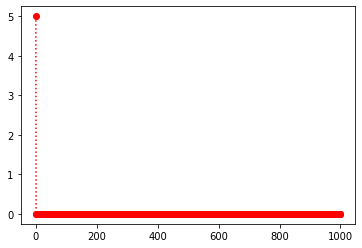

In [115]:
#     plt.plot(vrais_x_test[:,0],vrais_x_test[:,2],color='blue') #tracé du scénario généré (p_y en fonction de p_x)
#     plt.plot(moy_filtrage[:,0],moy_filtrage[:,2],color='red',linestyle='dotted',marker="o")
#     plt.plot(moy_kalman[:,0],moy_kalman[:,2],color='green',linestyle='dotted',marker="+")
#     plt.plot(moy_fp[:,0],moy_fp[:,2],color='yellow',linestyle='dotted',marker="P")
    
#     plt.figure()
#     plt.plot(moy_filtrage[:,1],color='red',linestyle='dotted',marker="o")
#     plt.plot(moy_kalman[:,1],color='green',linestyle='dotted',marker="+")
#     plt.plot(moy_fp[:,1],color='yellow',linestyle='dotted',marker="P")
#     plt.plot(vrais_x_test[:,1],color='blue')

plt.figure()
plt.plot(moy_filtrage,color='red',linestyle='dotted',marker="o")
plt.plot(moy_kalman,color='green',linestyle='dotted',marker="+")
plt.plot(moy_fp,color='yellow',linestyle='dotted',marker="P")
plt.plot(moy_fp_var,color='green',linestyle='dotted',marker="P")
plt.plot(vrais_x_test,color='blue')

In [116]:
plt.figure()
plt.plot(np.mean(MSE_vb,axis=0),color='red',linestyle='dotted',marker="o")
plt.plot(np.mean(MSE_fp,axis=0),color='yellow',linestyle='dotted',marker="P")   
#plt.plot(np.mean(MSE_imm,axis=0),color='black',linestyle='--',marker="D")

NameError: name 'MSE_vb' is not defined

<Figure size 432x288 with 0 Axes>

In [117]:
plt.figure()
plt.plot(np.mean(MSE_vb,axis=0)/np.mean(MSE_vb,axis=0),color='red',linestyle='dotted',marker="o")
#plt.plot(np.mean(MSE_vb_init,axis=0)/np.mean(MSE_vb,axis=0),color='brown',linestyle='dotted',marker="o")
plt.plot(np.mean(MSE_fp,axis=0)/np.mean(MSE_vb,axis=0),color='yellow',linestyle='dotted',marker="P")   
#plt.plot(np.mean(MSE_imm,axis=0)/np.mean(MSE_vb,axis=0),color='black',linestyle='--',marker="D")
plt.plot(np.mean(MSE_fp_var,axis=0)/np.mean(MSE_vb,axis=0),color='green',linestyle='dotted',marker="P")  

NameError: name 'MSE_vb' is not defined

<Figure size 432x288 with 0 Axes>

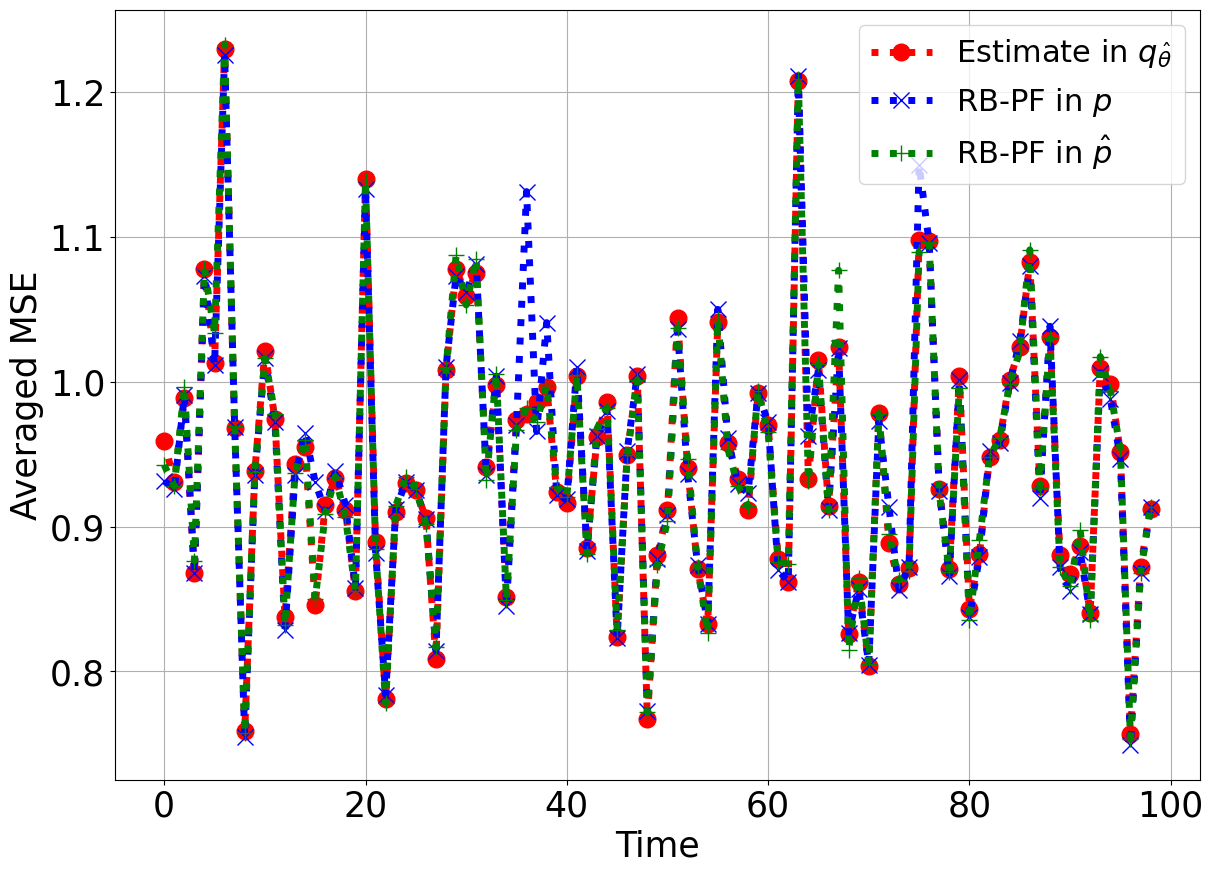

In [67]:
plt.figure(figsize = (14,10))
plt.rcParams.update({'font.size': 25})
plt.grid()
plt.plot(np.mean(MSE_vb,axis=0)[1:],color='red',linestyle='dotted',linewidth=5,marker="o",markersize=12,label='Estimate in $q_{\hat{\\theta}}$')
#plt.plot(np.mean(MSE_vb_init,axis=0)/np.mean(MSE_vb,axis=0),color='brown',linestyle='dotted',marker="o")
plt.plot(np.mean(MSE_fp,axis=0)[1:],color='blue',linestyle='dotted',linewidth=5,marker="x",markersize=12,label='RB-PF in $p$')   
#plt.plot(np.mean(MSE_imm,axis=0)/np.mean(MSE_vb,axis=0),color='black',linestyle='--',marker="D")
plt.plot(np.mean(MSE_fp_var,axis=0)[1:],color='green',linestyle='dotted',linewidth=5,marker="+",markersize=12,label='RB-PF in $\hat{p}$')  
plt.legend(fontsize=22)
plt.ylabel('Averaged MSE')
plt.xlabel('Time')

plt.savefig(f'fig1.pdf', bbox_inches = 'tight')


In [68]:
vt.pr_r_1.softmax(0)

tensor([[0.8253, 0.2033],
        [0.1747, 0.7967]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

In [43]:
np.mean(MSE_vb)

0.9325808164735153

In [44]:
np.mean(MSE_fp)

0.934824721029534

In [45]:
np.mean(MSE_imm)

0.9307271643649783

In [46]:
np.mean(MSE_vb_init)

89.27317818451215

In [47]:
np.mean(MSE_fp_var)

0.9327910762820735

In [48]:
np.mean(MSE_kalm)

0.9174746503691676

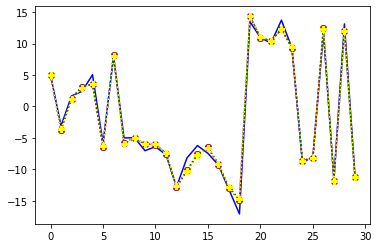

In [815]:
    plt.figure()
    plt.plot(vrais_x_test,color='blue') #tracé du scénario généré (p_y en fonction de p_x)
    plt.plot(moy_filtrage,color='red',linestyle='dotted',marker="o")
    plt.plot(moy_fp_var,color='brown',linestyle='dotted',marker="o")
    plt.plot(moy_kalman,color='green',linestyle='dotted',marker="+")
    plt.plot(moy_fp,color='yellow',linestyle='dotted',marker="P")

In [8]:
print(q_var_test.mat_trans)
print(q_var_init.mat_trans)
print(q_var_test.mat_trans_p)
print(mat_trans)


[[0.82638598 0.17361402]
 [0.20515575 0.79484425]]
[[0.90834032 0.09165968]
 [0.00521965 0.99478035]]
[[0.82526682 0.17473318]
 [0.20332851 0.79667149]]
[[0.8 0.2]
 [0.2 0.8]]


In [794]:
print('C_x',q_var_test.C_x)
print('C_x',q_var_init.C_x)
print('D_x',q_var_test.D_x)
print('D_x',q_var_init.D_x)
print('D_prime_x',q_var_test.D_prime_x)
print('D_prime_x',q_var_init.D_prime_x)
print('sigma_x',q_var_test.Sigma_x)
print('sigma_x',q_var_init.Sigma_x)
print('cte_x',q_var_test.cste_x)
print('cte_x',q_var_init.cste_x)
print('B_y',q_var_test.B_y)
print('B_y',q_var_init.B_y)
print('cte_y',q_var_test.cste_y)
print('cte_y',q_var_init.cste_y)
print('sigma_y',q_var_test.Sigma_y)
print('sigma_y',q_var_init.Sigma_y)
print('loi init',q_var_test.qr_0)
print('loi init',q_var_init.qr_0)

C_x [[[0.0424689 ]]

 [[0.19587869]]]
C_x [[[0.]]

 [[0.]]]
D_x [[[0.17340679]]

 [[0.19758865]]]
D_x [[[0.]]

 [[0.]]]
D_prime_x [[[0.]]

 [[0.]]]
D_prime_x [[[0.]]

 [[0.]]]
sigma_x [[[0.7019704 ]]

 [[0.74625999]]]
sigma_x [[[1.]]

 [[1.]]]
cte_x [[0.]
 [0.]]
cte_x [[0.]
 [0.]]
B_y [[[-0.10456235]]

 [[ 0.10830183]]]
B_y [[[0.]]

 [[0.]]]
cte_y [[0.]
 [0.]]
cte_y [[0.]
 [0.]]
sigma_y [[[0.68136704]]

 [[1.37909317]]]
sigma_y [[[1.]]

 [[1.]]]
loi init <built-in method numpy of Tensor object at 0x000002265BE3FAC0>


AttributeError: 'QVAR' object has no attribute 'qr_0'

In [9]:
print('F_var',F_var)
print('F',F)
print('H_var',H_var)
print('H',H)
print('Q_var',Q_var)
print('Q',Q)
print('R_var',R_var)
print('R',R)

F_var [[[-0.94882211]]

 [[ 0.94694723]]]
F [[[ 0.95]]

 [[-0.95]]]
H_var [[[1.]]

 [[1.]]]
H [[[1.]]

 [[1.]]]
Q_var [[[11.87482262]]

 [[11.88138962]]]
Q [[[10.]]

 [[10.]]]
R_var [[1.24393177]]
R [[1.]]


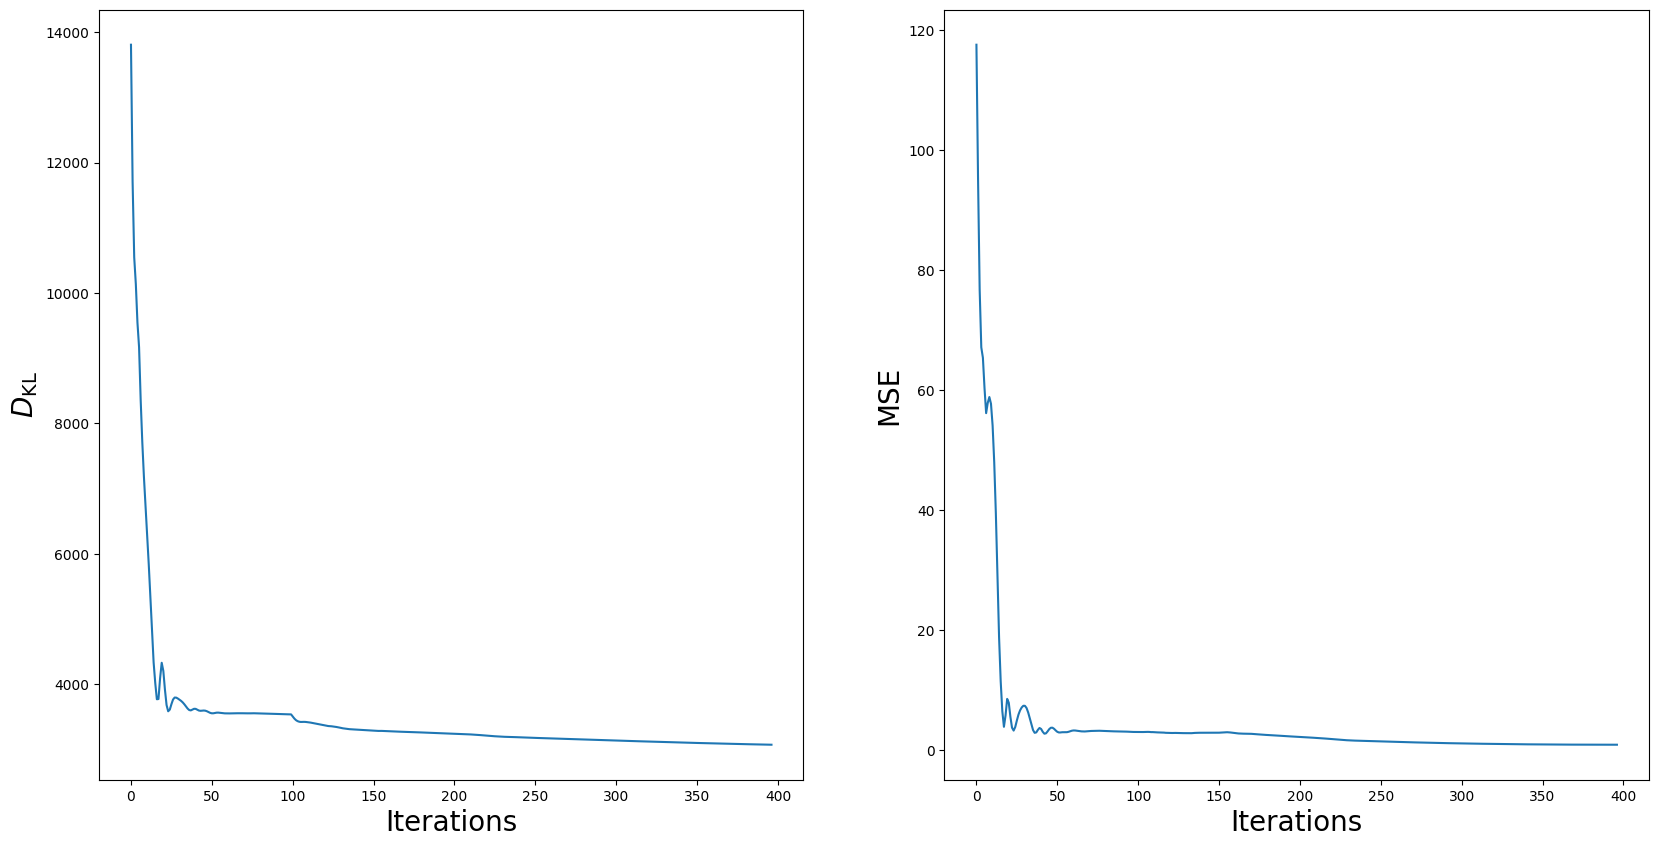

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
ax[0].plot(vt.divergence_values)
ax[0].set_xlabel('Iterations', fontsize = 20)
ax[0].set_ylabel('$D_{\mathrm{KL}}$', fontsize = 20)

ax[1].plot(vt.mean_squared_error)
ax[1].set_xlabel('Iterations', fontsize = 20)
ax[1].set_ylabel('MSE', fontsize = 20)
plt.rcParams.update()
plt.show()
